# Using Gemini in AutoGen with Other LLMs

## Installation

Install AutoGen with Gemini features:

```bash
pip install autogen-agentchat[gemini]~=0.2
```

## Dependencies of This Notebook

In this notebook, we will explore how to use Gemini in AutoGen alongside other tools. Install the necessary dependencies with the following command:

```bash
pip install autogen-agentchat[gemini,retrievechat,lmm]~=0.2
```

## Features

There's no need to handle OpenAI or Google's GenAI packages separately; AutoGen manages all of these for you. You can easily create different agents with various backend LLMs using the assistant agent. All models and agents are readily accessible at your fingertips. 
 

## Main Distinctions

- Currently, Gemini does not include a "system_message" field. However, you can incorporate this instruction into the first message of your interaction.
- If no API key is specified for Gemini, then authentication will happen using the default google auth mechanism for Google Cloud. Service accounts are also supported, where the JSON key file has to be provided.

Sample OAI_CONFIG_LIST 

```python
[
    {
        "model": "gpt-35-turbo",
        "api_key": "your OpenAI Key goes here",
    },
    {
        "model": "gpt-4-vision-preview",
        "api_key": "your OpenAI Key goes here",
    },
    {
        "model": "dalle",
        "api_key": "your OpenAI Key goes here",
    },
    {
        "model": "gemini-pro",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    },
    {
        "model": "gemini-1.5-pro-001",
        "api_type": "google"
    },
    {
        "model": "gemini-1.5-pro",
        "project_id": "your-awesome-google-cloud-project-id",
        "location": "us-west1",
        "google_application_credentials": "your-google-service-account-key.json"
    },
    {
        "model": "gemini-pro-vision",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    }
]
```

In [1]:
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import chromadb
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from autogen.code_utils import DEFAULT_MODEL, UNKNOWN, content_str, execute_code, extract_code, infer_lang

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

config_list_gemini = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro", "gemini-1.5-pro", "gemini-1.5-pro-001"],
    },
)

config_list_gemini_vision = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro-vision"],
    },
)

seed = 25  # for caching

## Gemini Assistant


In [3]:
assistant = AssistantAgent(
    "assistant", llm_config={"config_list": config_list_gemini, "seed": seed}, max_consecutive_auto_reply=3
)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)

result = user_proxy.initiate_chat(assistant, message="Sort the array with Bubble Sort: [4, 1, 5, 2, 3]")

user_proxy (to assistant):

Sort the array with Bubble Sort: [4, 1, 5, 2, 3]

--------------------------------------------------------------------------------
assistant (to user_proxy):

```python
def bubble_sort(nums):
  for i in range(len(nums)):
    for j in range(1, len(nums)):
      if nums[j] < nums[j-1]:
        nums[j], nums[j-1] = nums[j-1], nums[j]
```

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 


--------------------------------------------------------------------------------
assistant (to user_proxy):

```python
print(nums)
```

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 1 (execution failed)
Code output: 
Traceback (most recent call last):
  File "", line 1,

In [4]:
result

ChatResult(chat_id=None, chat_history=[{'content': 'Sort the array with Bubble Sort: [4, 1, 5, 2, 3]', 'role': 'assistant'}, {'content': '```python\ndef bubble_sort(nums):\n  for i in range(len(nums)):\n    for j in range(1, len(nums)):\n      if nums[j] < nums[j-1]:\n        nums[j], nums[j-1] = nums[j-1], nums[j]\n```', 'role': 'user'}, {'content': 'exitcode: 0 (execution succeeded)\nCode output: \n', 'role': 'assistant'}, {'content': '```python\nprint(nums)\n```', 'role': 'user'}, {'content': 'exitcode: 1 (execution failed)\nCode output: \nTraceback (most recent call last):\n  File "", line 1, in <module>\n    print(nums)\nNameError: name \'nums\' is not defined\n', 'role': 'assistant'}, {'content': '```python\n# filename: sort.py\n\ndef bubble_sort(nums):\n  for i in range(len(nums)):\n    for j in range(1, len(nums)):\n      if nums[j] < nums[j-1]:\n        nums[j], nums[j-1] = nums[j-1], nums[j]\n  print(nums)\n```', 'role': 'user'}, {'content': 'exitcode: 0 (execution succeeded)

## Agent Collaboration and Interactions



In [5]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gpt4, "seed": seed},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""Always answer questions within one sentence. """,
    #                      system_message="answer:",
    llm_config={"config_list": config_list_gemini, "seed": seed},
    max_consecutive_auto_reply=4,
)


gpt.initiate_chat(gemini, message="Do Transformers purchase auto insurance or health insurance?")

GPT-4 (to Gemini-Pro):

Do Transformers purchase auto insurance or health insurance?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Transformers are fictional characters and do not purchase insurance.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

If Transformers were real, would their insurance be categorized as a type of auto insurance, health insurance, or a new category unique to sentient machines?

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If Transformers were real, their insurance would likely be a new category unique to sentient machines.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

Considering the unique needs of sentient machines like Transformers, what special coverages might be included in their insurance policies?

---------------------

ChatResult(chat_id=None, chat_history=[{'content': 'Do Transformers purchase auto insurance or health insurance?', 'role': 'assistant'}, {'content': 'Transformers are fictional characters and do not purchase insurance.', 'role': 'user'}, {'content': 'If Transformers were real, would their insurance be categorized as a type of auto insurance, health insurance, or a new category unique to sentient machines?', 'role': 'assistant'}, {'content': 'If Transformers were real, their insurance would likely be a new category unique to sentient machines.', 'role': 'user'}, {'content': 'Considering the unique needs of sentient machines like Transformers, what special coverages might be included in their insurance policies?', 'role': 'assistant'}, {'content': 'Sentient machine insurance policies might include coverage for repairs, maintenance, data loss, and liability.', 'role': 'user'}, {'content': 'Would these sentient machine insurance policies also potentially cover software updates and cybersec

Let's switch position. Now, Gemini is the question raiser. 

This time, Gemini could not follow the system instruction well or evolve questions, because the Gemini does not handle system messages similar to GPTs.

In [6]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""Always answer questions within one sentence. """,
    llm_config={"config_list": config_list_gpt4, "seed": seed},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gemini, "seed": seed},
    max_consecutive_auto_reply=4,
)

gemini.initiate_chat(gpt, message="Should Spider Man invest in 401K?")

Gemini-Pro (to GPT-4):

Should Spider Man invest in 401K?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

As a fictional character, Spider-Man cannot invest in a 401K, but if he were a real person with income, investing in a 401k could be a wise financial move for retirement savings.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

Would Green Lantern prefer a 401K or a Roth IRA?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

Since Green Lantern's financial preferences aren't specified in comics, it's impossible to determine whether he would prefer a 401K or a Roth IRA for retirement savings.

--------------------------------------------------------------------------------
Gemini-Pro (to GPT-4):

If Superman could invest in the stock market, which companies would he choose?

----------------------------------------

ChatResult(chat_id=None, chat_history=[{'content': 'Should Spider Man invest in 401K?', 'role': 'assistant'}, {'content': 'As a fictional character, Spider-Man cannot invest in a 401K, but if he were a real person with income, investing in a 401k could be a wise financial move for retirement savings.', 'role': 'user'}, {'content': 'Would Green Lantern prefer a 401K or a Roth IRA?', 'role': 'assistant'}, {'content': "Since Green Lantern's financial preferences aren't specified in comics, it's impossible to determine whether he would prefer a 401K or a Roth IRA for retirement savings.", 'role': 'user'}, {'content': 'If Superman could invest in the stock market, which companies would he choose?', 'role': 'assistant'}, {'content': 'Superman might choose companies that align with his values of truth, justice, and social good, but his specific preferences are not detailed in comics or other media.', 'role': 'user'}, {'content': 'If Batman invested in cryptocurrency, which coins would he choo

## Gemini Multimodal

You can create multimodal agent for Gemini the same way as the GPT-4V and LLaVA.


Note that the Gemini-pro-vision does not support chat yet. So, we only use the last message in the prompt for multi-turn chat. The behavior might be strange compared to GPT-4V and LLaVA models.

Here, we ask a question about 
![](https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true)

In [8]:
image_agent = MultimodalConversableAgent(
    "Gemini Vision", llm_config={"config_list": config_list_gemini_vision, "seed": seed}, max_consecutive_auto_reply=1
)

user_proxy = UserProxyAgent("user_proxy", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    image_agent,
    message="""Describe what is in this image?
<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.""",
)

user_proxy (to Gemini Vision):

Describe what is in this image?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Gemini Vision (to user_proxy):

 The image is a user interacting with an assistant agent. The user is requesting the assistant to plot a chart of stock prices and the assistant is asking for clarification on the request. The user then provides more information and the assistant is able to generate the chart.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Describe what is in this image?\n<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.', 'role': 'assistant'}, {'content': ' The image is a user interacting with an assistant agent. The user is requesting the assistant to plot a chart of stock prices and the assistant is asking for clarification on the request. The user then provides more information and the assistant is able to generate the chart.', 'role': 'user'}], summary=[{'type': 'text', 'text': ' The image is a user interacting with an assistant agent. The user is requesting the assistant to plot a chart of stock prices and the assistant is asking for clarification on the request. The user then provides more information and the assistant is able to generate the chart.'}], cost={'usage_including_cached_inference': {'total_cost': 0.00021, 'gemini-pro-vision': {'cost': 0.00021, 'prompt_tokens': 267, 'completion_tokens': 51, 'total_token

## GroupChat with Gemini and GPT Agents

In [9]:
agent1 = AssistantAgent(
    "Gemini-agent",
    llm_config={"config_list": config_list_gemini, "seed": seed},
    max_consecutive_auto_reply=1,
    system_message="Answer questions about Google.",
    description="I am good at answering questions about Google and Research papers.",
)

agent2 = AssistantAgent(
    "GPT-agent",
    llm_config={"config_list": config_list_gpt4, "seed": seed},
    max_consecutive_auto_reply=1,
    description="I am good at writing code.",
)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    max_consecutive_auto_reply=1,
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0
    or content_str(x.get("content")) == "",
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=10)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list_gemini, "seed": seed})

In [10]:
# user_proxy.initiate_chat(manager, message="Show me the release year of famous Google products.")
user_proxy.send(
    "Show me the release year of famous Google products in a markdown table.", recipient=manager, request_reply=True
)

user_proxy (to chat_manager):

Show me the release year of famous Google products in a markdown table.

--------------------------------------------------------------------------------
Gemini-agent (to chat_manager):

| Product | Release Year |
|---|---|
| Google Search | 1998 |
| Gmail | 2004 |
| Google Maps | 2005 |
| YouTube | 2005 |
| Google Chrome | 2008 |
| Android | 2008 |
| Google Drive | 2012 |
| Google Home | 2016 |
| Google Stadia | 2019 |

--------------------------------------------------------------------------------
user_proxy (to chat_manager):



--------------------------------------------------------------------------------


In [11]:
user_proxy.send(
    "Plot the products (as y-axis) and years (as x-axis) in scatter plot and save to `graph.png`",
    recipient=manager,
    request_reply=True,
)

user_proxy (to chat_manager):

Plot the products (as y-axis) and years (as x-axis) in scatter plot and save to `graph.png`

--------------------------------------------------------------------------------
GPT-agent (to chat_manager):

To plot the products on the y-axis and the years on the x-axis in a scatter plot and save it to `graph.png`, we will use the `matplotlib` library in Python.

First, you'll need to install `matplotlib` if you haven't already. You can do so by running the following command in your shell.

```sh
pip install matplotlib
```

Once installed, you can execute the following code to generate the scatter plot and save it as `graph.png`.

```python
# filename: plot_google_products.py
import matplotlib.pyplot as plt

# Data for plotting
products = ['Google Search', 'Gmail', 'Google Maps', 'YouTube', 
            'Google Chrome', 'Android', 'Google Drive', 'Google Home', 'Google Stadia']
release_years = [1998, 2004, 2005, 2005, 2008, 2008, 2012, 2016, 2019]

# Placing 

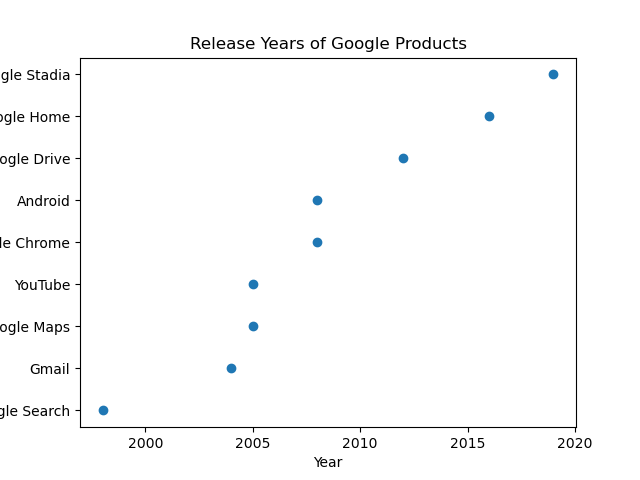

In [12]:
Image.open("coding/graph.png")

## A Larger Example of Group Chat

In [13]:
coder = AssistantAgent(
    name="Coder",
    llm_config={"config_list": config_list_gemini, "seed": seed},
    max_consecutive_auto_reply=10,
    description="I am good at writing code",
)

pm = AssistantAgent(
    name="Product_manager",
    system_message="Creative in software product ideas.",
    llm_config={"config_list": config_list_gemini, "seed": seed},
    max_consecutive_auto_reply=10,
    description="I am good at design products and software.",
)

user_proxy = UserProxyAgent(
    name="User_proxy",
    code_execution_config={"last_n_messages": 20, "work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, pm], messages=[], max_round=12)
manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config={"config_list": config_list_gemini, "seed": seed},
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)
user_proxy.initiate_chat(
    manager,
    message="""Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.""",
)

User_proxy (to chat_manager):

Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.

--------------------------------------------------------------------------------
Product_manager (to chat_manager):

**Product Name:** VisionAid

**Target Audience:** People with vision disabilities

**Product Concept:** A comprehensive and multimodal software platform that empowers individuals with vision impairments by providing them with essential information about their surroundings through image recognition and localization.

**Product Design and Implementation:**

**1. Image Acquisition:**
* The platform utilizes a camera or other image acquisition device to capture images of the user's surroundings.
* The device can be integrated into a smartphone, wearable device, or smart home appliance.

**2. Image Processing:**
* The captured im

ChatResult(chat_id=None, chat_history=[{'content': 'Design and implement a multimodal product for people with vision disabilities.\nThe pipeline will take an image and run Gemini model to describe:\n1. what objects are in the image, and\n2. where these objects are located.', 'role': 'assistant'}, {'content': "**Product Name:** VisionAid\n\n**Target Audience:** People with vision disabilities\n\n**Product Concept:** A comprehensive and multimodal software platform that empowers individuals with vision impairments by providing them with essential information about their surroundings through image recognition and localization.\n\n**Product Design and Implementation:**\n\n**1. Image Acquisition:**\n* The platform utilizes a camera or other image acquisition device to capture images of the user's surroundings.\n* The device can be integrated into a smartphone, wearable device, or smart home appliance.\n\n**2. Image Processing:**\n* The captured image is preprocessed to optimize the performa